# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky iportujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

## Steps:
1. Think
2. Download data
3. Parse data
4. Visualize
5. ??
6. Profit

## Download Data - nespúštať ak nechcete downloadovať, všetko je v priečinku ../data ./results.csv

In [1]:
# !python3.8 ./main.py

In [77]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Matplotlib umožňuje změnit styl na jiný, než defaultní
matplotlib.style.use('ggplot')

# Bez násl. řádku někdy nefunguje vykreslování grafů v Jupyter noteboocích
%matplotlib inline 

#### Vlastná classa, ktorá obsahuje jedno hlasovanie z 61 hlasovanie

In [78]:
class CProposal:
    def __init__(self, meeting_n=None, voting_n=None, url=None, response=None):
        if meeting_n is not None:
            self.meeting_n = meeting_n
            self.voting_n = voting_n
            soup = BeautifulSoup(response.text, 'html.parser')
            results_tag = soup.find_all('ul', class_='results')
            self.overall_df = pd.read_html(response.text)[1]
            self.overall_df.columns = ["Party", 'N. repr.', 'A', 'N', '0', 'Z', 'M']
            self.overall_df = self.overall_df.assign(Meeting=self.meeting_n)
            self.overall_df = self.overall_df.assign(Proposal=self.voting_n)
            self.df = pd.DataFrame(columns=['Name', 'Party', 'Vote', 'Meeting', 'Proposal'])
            for party in results_tag:
                party_name = str(party.previous_sibling.contents[0].next)[:-2]
                for member in party:
                    row = pd.Series(data={'Name': member.contents[2].string, "Party": party_name,
                                          "Vote": member.contents[0].string, 'Meeting': meeting_n,
                                          'Proposal': voting_n})
                    self.df = self.df.append(row, ignore_index=True)

    def load(self, filename):
        uscore_pos = str(filename).find('_')
        dash_pos = str(filename).find('-')
        dot_pos = str(filename).find('.')
        pos = 0
        if dash_pos < 0:
            pos = uscore_pos
        else:
            pos = dash_pos
        self.meeting_n = int(str(filename)[:pos])
        self.voting_n = int(str(filename)[pos + 1:dot_pos])
        uscorefile = str(self.meeting_n) + '_' + str(self.voting_n) + '.csv'
        dashfile = str(self.meeting_n) + '-' + str(self.voting_n) + '.csv'
        ban = ''
        if dash_pos < 0:
            ban = dashfile
        else:
            ban = uscorefile
        self.df = pd.read_csv('../data/' + uscorefile)
        self.overall_df = pd.read_csv('../data/' + dashfile)
        return ban

    def save(self):
        print('Saving: m: ' + str(self.meeting_n) + ' p: ' + str(self.voting_n))
        members_file = '../data/' + str(self.meeting_n) + '_' + str(self.voting_n) + '.csv'
        party_file = '../data/' + str(self.meeting_n) + '-' + str(self.voting_n) + '.csv'
        self.df.to_csv(members_file, index=False)
        self.overall_df.to_csv(party_file, index=False)

## Load from files

In [79]:
import glob

In [80]:
df = pd.concat(map(pd.read_csv, glob.glob('../data/*_*.csv')), ignore_index=True)

In [81]:
df_overall = pd.concat(map(pd.read_csv, glob.glob('../data/*-*.csv')), ignore_index=True)

In [82]:
a = df.Meeting.unique()
a.sort(axis=0)
display(a)
display(df_overall.Party.unique())

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61], dtype=object)

array(['ANO', 'ODS', 'Piráti', 'SPD', 'ČSSD', 'KSČM', 'KDU-ČSL', 'TOP09',
       'STAN', 'Celkem', 'Nezařaz'], dtype=object)

In [236]:
display(df.head())
display(df.tail())

,Name,Party,Vote,Meeting,Proposal
0,Věra Adámková,ANO,A,10,1
1,Andrej Babiš,ANO,A,10,1
2,Andrea Babišová,ANO,A,10,1
3,Margita Balaštíková,ANO,A,10,1
4,Josef Bělica,ANO,A,10,1


,Name,Party,Vote,Meeting,Proposal
1407795,Petr Gazdík,STAN,A,9,4
1407796,Věra Kovářová,STAN,A,9,4
1407797,Jana Krutáková,STAN,A,9,4
1407798,Petr Pávek,STAN,A,9,4
1407799,Vít Rakušan,STAN,A,9,4


In [226]:
display(df_overall.head())
display(df_overall.tail())

,Party,N. repr.,A,N,0,Z,M,Meeting,Proposal
0,ANO,78,74,0,2,2,0,1,1
1,ODS,25,24,0,1,0,0,1,1
2,Piráti,22,22,0,0,0,0,1,1
3,SPD,22,22,0,0,0,0,1,1
4,ČSSD,15,13,0,0,2,0,1,1


,Party,N. repr.,A,N,0,Z,M,Meeting,Proposal
74999,KSČM,15,0,1,4,8,2,9,4
75000,KDU-ČSL,10,8,0,0,0,2,9,4
75001,TOP09,7,7,0,0,0,0,9,4
75002,STAN,6,6,0,0,0,0,9,4
75003,Celkem,200,78,41,7,58,16,9,4


# Prebehnutia v stranach

In [85]:
change = {}
for representative in df['Name'].unique():
    repr = (df[df['Name'] == representative])['Party'].unique().tolist()
    if len(repr) > 1:
        change[representative] = repr
change_df = pd.DataFrame(columns={'Name', 'From', 'To'})
for representative in change:
    match = df[(df['Meeting'] == 1) & (df['Proposal'] == 1) & (df['Name'] == representative)]
    _from = match.Party.iloc[0]
    change[representative].remove(_from)
    _to = change[representative]
    change_df = change_df.append({'Name':representative, "From": _from, "To": _to }, ignore_index=True)

,To,Name,From
0,[Nezařaz],Tereza Hyťhová,SPD
1,"[SPD, Nezařaz]",Jaroslav Foldyna,ČSSD
2,[Nezařaz],Marian Bojko,SPD
3,[Nezařaz],Václav Klaus,ODS
4,[Nezařaz],Zuzana Majerová Zahradníková,ODS
5,[Nezařaz],Ivana Nevludová,SPD
6,[Nezařaz],Lubomír Volný,SPD


,0
From,
ODS,2
SPD,4
ČSSD,1


<AxesSubplot:xlabel='From'>

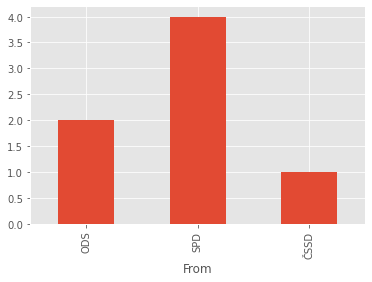

In [198]:
display(change_df)
dd = pd.DataFrame(change_df.groupby('From').size())
display(dd)
dd.plot(kind='bar', legend=False)

# Dochádzka poslancov

In [227]:
representatives_attendance = {}
total = 0
for representative in df['Name'].unique():
    votings = df.loc[df['Name'] == representative]
    votings = votings.reset_index()

    c = votings.groupby(['Vote']).size()#.drop(index=0)
    representatives_attendance[representative] = c
    total = 0
    for vote in c:
        total += vote
    representatives_attendance[representative]['Total'] = total
    representatives_attendance[representative]['Party'] = votings.Party[0]

In [228]:
colors = {'Nezařaz': 'black', 'ANO': 'r', 'ODS':'b', 'Piráti':'g', 'SPD':'violet', 'ČSSD':'orchid', 'KSČM':'tomato', 'KDU-ČSL':'mediumblue', 'TOP09':'azure', 'STAN':'lime'}
attendance_df = pd.DataFrame(representatives_attendance).T
attendance_df = attendance_df.fillna(0)
attendance_df['Dochádzka'] = (attendance_df['A'] + attendance_df['N'] + attendance_df['Z']) / attendance_df['Total'] * 100
attendance_df = attendance_df.sort_values(by=['Dochádzka'], ascending=False)

Najlepšia dochádzka:


,0,0,A,M,N,Z,Total,Party,Dochádzka
Martin Půta,0,0,13,0,2,1,16,STAN,100.000000
Jiří Hlavatý,0,0,12,0,3,1,16,ANO,100.000000
Radek Rozvoral,1,27,5262,0,593,1156,7039,SPD,99.602216
Roman Kubíček,1,49,3413,11,2307,1258,7039,ANO,99.133400
Ondřej Babka,1,35,1656,5,890,726,3313,ANO,98.762451




Najhoršia dochádzka:


,0,0,A,M,N,Z,Total,Party,Dochádzka
Jan Hamáček,1,1666,1004,2236,608,1524,7039,ČSSD,44.551783
Martin Stropnický,0,150,295,557,131,76,1209,ANO,41.521919
Jana Levová,1,452,1913,3821,226,626,7039,SPD,39.281148
Karel Schwarzenberg,1,931,1485,3998,209,415,7039,TOP09,29.961642
Andrej Babiš,1,482,600,4863,638,455,7039,ANO,24.051712


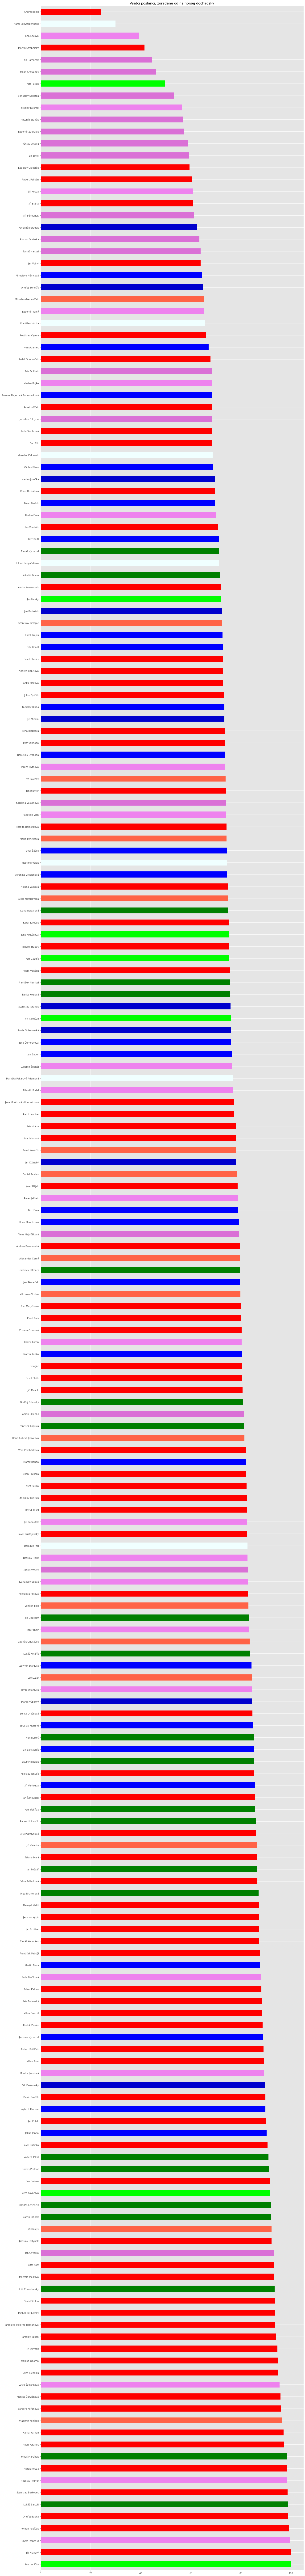

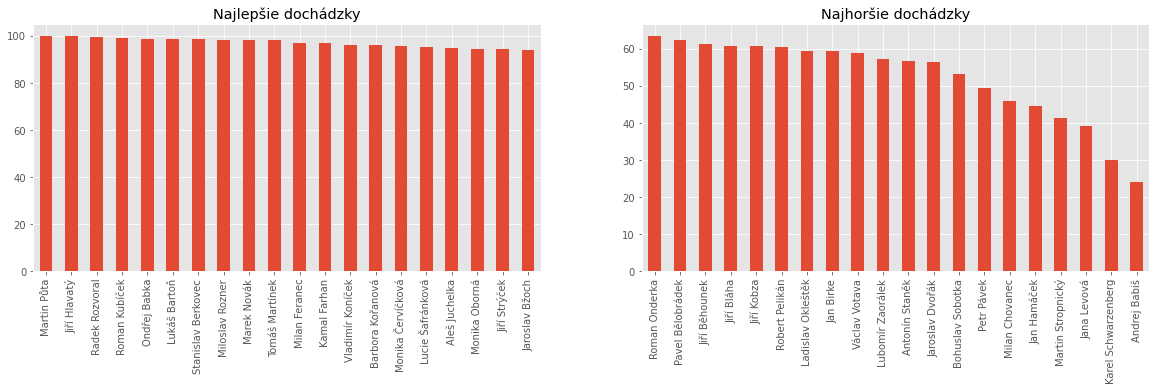

In [229]:
plt.figure(figsize=(20,200))
plt.title('Všetci poslanci, zoradené od najhoršej dochádzky')
a = attendance_df[['Dochádzka','Party']]
l = a['Party'].map(colors)
a['Dochádzka'].plot(kind='barh', color=l)
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.title('Najlepšie dochádzky')
attendance_df.head(20)['Dochádzka'].plot.bar()
plt.subplot(222)
plt.title('Najhoršie dochádzky')
attendance_df.tail(20)['Dochádzka'].plot.bar()
print("Najlepšia dochádzka:")
display(attendance_df.head(5))
print('\n')
print("Najhoršia dochádzka:")
display(attendance_df.tail(5))

# Dochádzka podľa strán

In [43]:
party_total = {}
party_att = {}
party_perc = {}
party_data = pd.DataFrame(columns={'Party', "Total", "Attended", 'Percent'})
party_att_df = pd.DataFrame(columns={"Party", "N. repr.", "A", "N", "0", "Z", "M", "Meeting","Proposal"})
for party in df_overall.Party.unique():
    total_meeting = 0
    total_attend = 0
    for meeting in df_overall.Meeting.unique():
        for proposal in df_overall[df_overall.Meeting == meeting].Proposal.unique():
            party_att = df_overall[ (df_overall['Party'] == party) & (df_overall['Proposal'] == proposal) 
                              & (df_overall['Meeting'] == meeting)]
            total_meeting += party_att['A'].iloc[0]
            total_meeting += party_att['N'].iloc[0]
            total_meeting += party_att['Z'].iloc[0]
            total_meeting += party_att['M'].iloc[0]
            total_meeting += party_att['0'].iloc[0]
            total_attend += party_att['A'].iloc[0]
            total_attend += party_att['N'].iloc[0]
            total_attend += party_att['Z'].iloc[0]
            party_att_df = party_att_df.append(party_att)
    party_data = party_data.append({"Party": party, "Total": total_meeting, 'Attended': total_attend, 'Percent': total_attend/total_meeting*100}, ignore_index=True)

In [ ]:
display(party_data)
display(party_att_df)

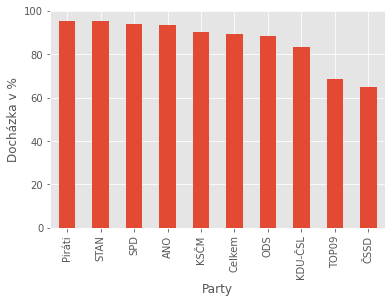

In [207]:
party_data = party_data.sort_values(by=['Percent'], ascending=False)
party_data.plot(x='Party', y='Percent', kind='bar', legend=False)
plt.ylabel('Docházka v %')
plt.show()

# Zhoda v hlasovani medzi stranami

In [9]:
match_df = df_overall.drop(columns=['A', 'Z', '0', 'N. repr.', 'M', 'N'])
match_df

,Party,Meeting,Proposal
0,ANO,1,1
1,ODS,1,1
2,Piráti,1,1
3,SPD,1,1
4,ČSSD,1,1
...,...,...,...
74999,KSČM,9,4
75000,KDU-ČSL,9,4
75001,TOP09,9,4
75002,STAN,9,4


Vytvoril som novy stlpec [Vote(Party)], kde sa zobrazuje vacsinovy vysledok hlasovania strany v konkretnom hlasovanie. Ten sa potom porovnava s hlasom kazdeho poslanca.

In [18]:
for party in df_overall['Party'].unique():
    match_df['A'] = df_overall['A'] / df_overall['N. repr.'] * 100
    match_df['N'] = df_overall['N'] / df_overall['N. repr.'] * 100
    match_df['Z'] = df_overall['Z'] / df_overall['N. repr.'] * 100
match_df.dropna(inplace=True)
df_test = df_overall[['A', 'N', 'Z']].astype(str).astype(int)
match_df['Vote(Party)'] = df_test[['A', 'N', 'Z']].idxmax(1)
match_df.drop(columns=['A', 'N', 'Z'], inplace=True)
match_df = match_df[match_df.Party != 'Celkem']

In [19]:
p_df = match_df.copy(deep=True)

In [240]:
votes_dict = {}
for party in match_df['Party'].unique():
    votes_dict[party] = {}
    for second_party in np.delete(match_df['Party'].unique(), np.where(match_df['Party'].unique() == party)):
        votes_dict[party][second_party] = 0

for meeting in match_df['Meeting'].unique():
    meeting_df = match_df.loc[match_df['Meeting'] == meeting]
    for voting in meeting_df['Proposal'].unique():
        voting_df = meeting_df.loc[meeting_df['Proposal'] == voting]
        for vote in voting_df['Vote(Party)'].unique():
            parties_df = voting_df.loc[voting_df['Vote(Party)'] == vote]
            for party in parties_df['Party'].unique():
                for second_party in np.delete(parties_df['Party'].unique(), np.where(parties_df['Party'].unique() == party)):
                    votes_dict[party][second_party] += 1

In [241]:
voting_stats = pd.DataFrame(votes_dict)
for party in voting_stats:
    voting_stats.loc[party] = voting_stats.loc[party] / 100  

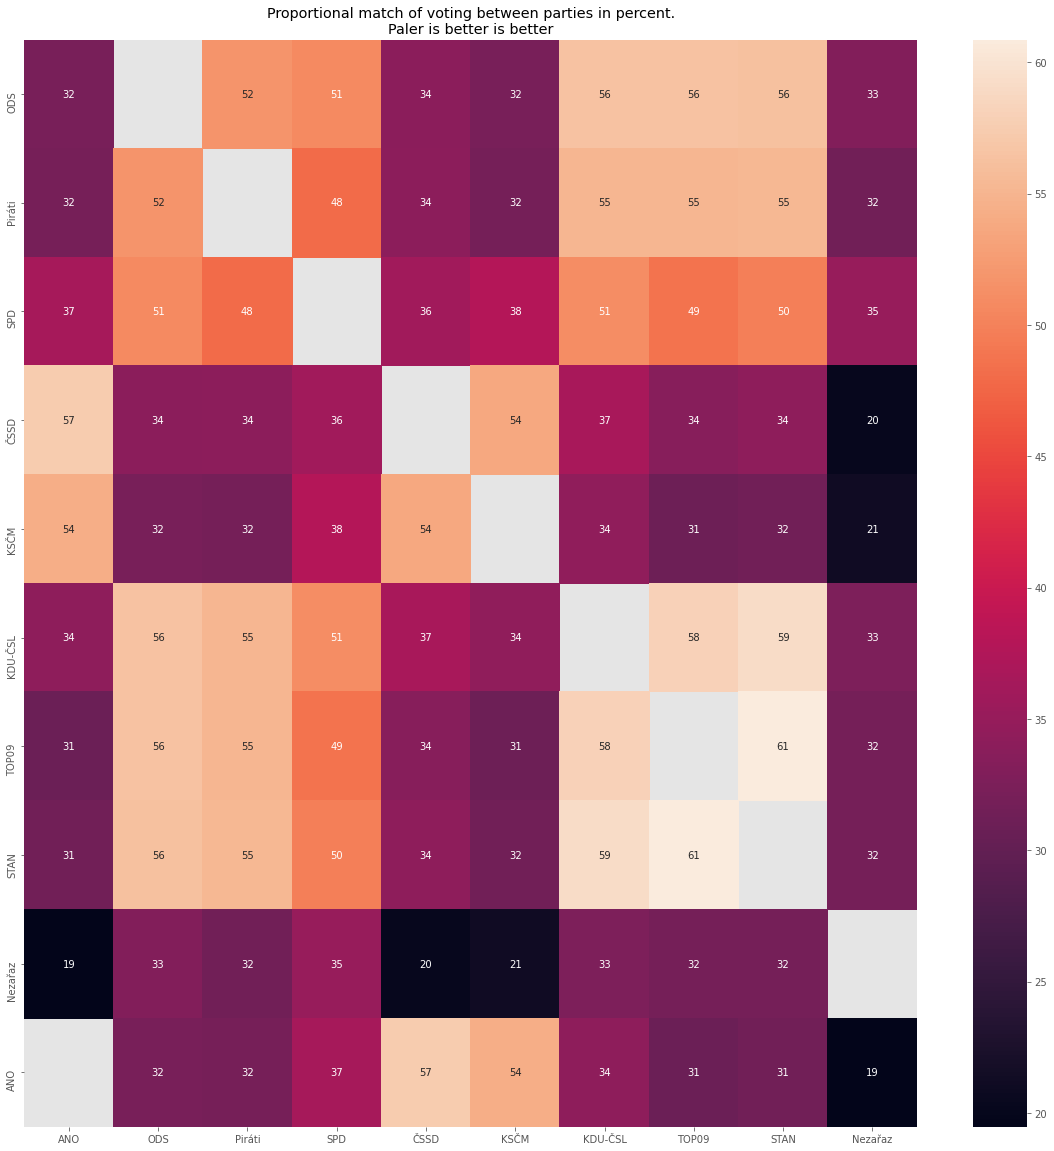

In [242]:
plt.figure(figsize=(20,20))
plt.title('Proportional match of voting between parties in percent.\nPaler is better is better')
sns.heatmap(voting_stats, annot=True)

# Zhoda poslancov ku hlasovaniu vlastnej strany

In [29]:
from collections import Counter

In [32]:
loyalty = {}
for name in df.Name.unique():
    avg_party_votes = df.loc[df['Name'] == name][(df['Vote'] == 'A')|(df['Vote'] == 'N')|(df['Vote'] == 'Z')]
    rep_party_merge_df = pd.merge(avg_party_votes, match_df[match_df['Party'] == avg_party_votes['Party'].unique()[0]])
    if not len(np.where(rep_party_merge_df['Vote(Party)'] == rep_party_merge_df['Vote'], 1, 0)):
        continue
    else:
        c = Counter(np.where(rep_party_merge_df['Vote(Party)'] == rep_party_merge_df['Vote'], 1, 0))
    loyalty[name] = c[1] / (c[1] + c[0]) * 100

<ipython-input-32-ce0eaf36edc2>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_party_votes = df.loc[df['Name'] == name][(df['Vote'] == 'A')|(df['Vote'] == 'N')|(df['Vote'] == 'Z')]


## Lojálnosť

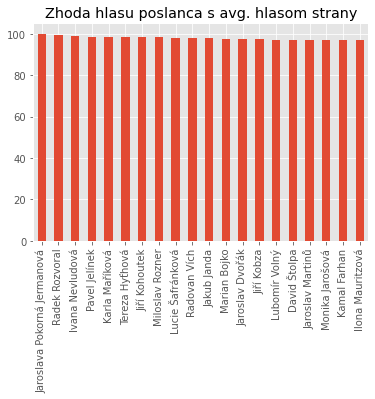

In [33]:
dfp = pd.DataFrame([loyalty]).T
dfp = dfp.sort_values(by=0, ascending=False)
dfp.head(20).plot.bar(legend=False, title='Zhoda hlasu poslanca s avg. hlasom strany')

## Rebelanstvo

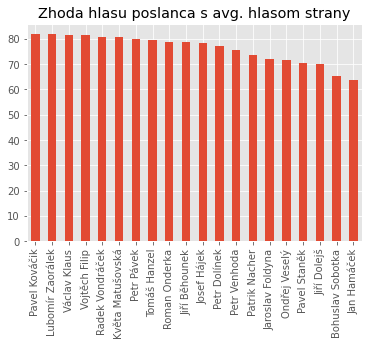

In [34]:
dfp = pd.DataFrame([loyalty]).T
dfp = dfp.sort_values(by=0, ascending=False)
dfp.tail(20).plot.bar(legend=False, title='Zhoda hlasu poslanca s avg. hlasom strany')

# BONUS BONUS BONUS BONUS BONUS BONUS

1. Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
#### Vývoj účasti na hlasovaniach strany

In [ ]:
party_total = {}
party_att = {}
party_perc = {}
total ={"ANO":78, "ODS":25, "Piráti":22, "SPD":22, "ČSSD":25, "KSČM":15,
"KDU-ČSL":10, "TOP09":7, "STAN":6, "Celkem":200}
        party_data = pd.DataFrame(columns={'Party', "Total", "Attended", 'Meeting', 'Ratio'})
for party in df_overall.Party.unique():
    total_meeting = 0
    total_attend = 0
    ttt = total[party]
    for meeting in df_overall.Meeting.unique():
        for proposal in df_overall[df_overall.Meeting == meeting].Proposal.unique():
            party_att = df_overall[ (df_overall['Party'] == party) & (df_overall['Proposal'] == proposal) 
                              & (df_overall['Meeting'] == meeting)]
            total_meeting += ttt
            total_attend += party_att['A'].iloc[0]
            total_attend += party_att['N'].iloc[0]
            total_attend += party_att['Z'].iloc[0]          
        party_data = party_data.append({"Party": party, "Total": total_meeting, 
                                        'Attended': total_attend,'Meeting': meeting,
                                        'Ratio':total_attend/total_meeting},ignore_index=True)

In [ ]:
party_data['Meeting'] = party_data['Meeting'].astype(str).astype(int)
party_data.drop(columns=['Attended','Total'], inplace=True)

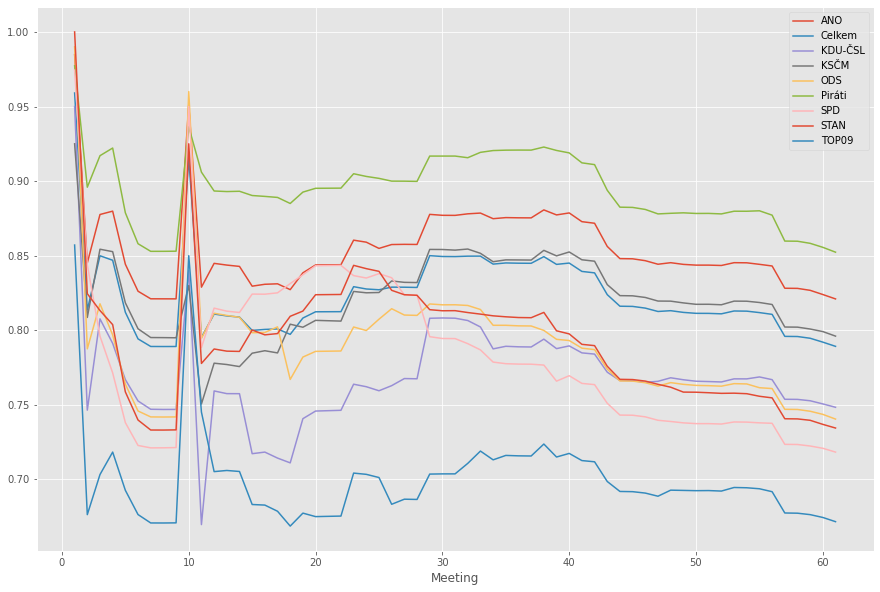

In [113]:
party_data.sort_values(by='Meeting', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(15,10))
for party, df in party_data.groupby('Party'):
    if party == 'ČSSD':
        continue
    df.plot(x='Meeting', y='Ratio', ax=ax, label=party)

### Pozorovanie:
Na grafe vidíme vysokú účasť na 1. a 10. hlasovaní, môžeme to pozorovať aj z Raw data:

In [125]:
display(party_data[party_data['Meeting'] == 1].sort_values(by='Ratio', ascending = True))
display(party_data[party_data['Meeting'] == 10].sort_values(by='Ratio', ascending = True))


,Meeting,Ratio,Party
240,1,0.477500,ČSSD
420,1,0.857143,TOP09
300,1,0.925000,KSČM
360,1,0.950000,KDU-ČSL
540,1,0.959063,Celkem
180,1,0.974432,SPD
120,1,0.977273,Piráti
0,1,0.984776,ANO
60,1,0.990000,ODS
480,1,1.000000,STAN


,Meeting,Ratio,Party
241,10,0.440000,ČSSD
301,10,0.830000,KSČM
361,10,0.840000,KDU-ČSL
421,10,0.850000,TOP09
541,10,0.915250,Celkem
481,10,0.925000,STAN
121,10,0.936364,Piráti
181,10,0.950000,SPD
1,10,0.951282,ANO
61,10,0.960000,ODS


#### Strana ANO mala najvyššiu účasť práve na hlasovaniach 1 a 10:

In [126]:
display(party_data[party_data['Party'] == 'ANO'].sort_values(by='Ratio', ascending = False).head(10))

,Meeting,Ratio,Party
0,1,0.984776,ANO
1,10,0.951282,ANO
30,38,0.880690,ANO
32,4,0.879859,ANO
33,40,0.878658,ANO
25,33,0.878568,ANO
24,32,0.878059,ANO
20,29,0.877697,ANO
21,3,0.877610,ANO
31,39,0.877328,ANO


### Oddelil som stranu ČSSD, pretoze znizovala presnost grafu

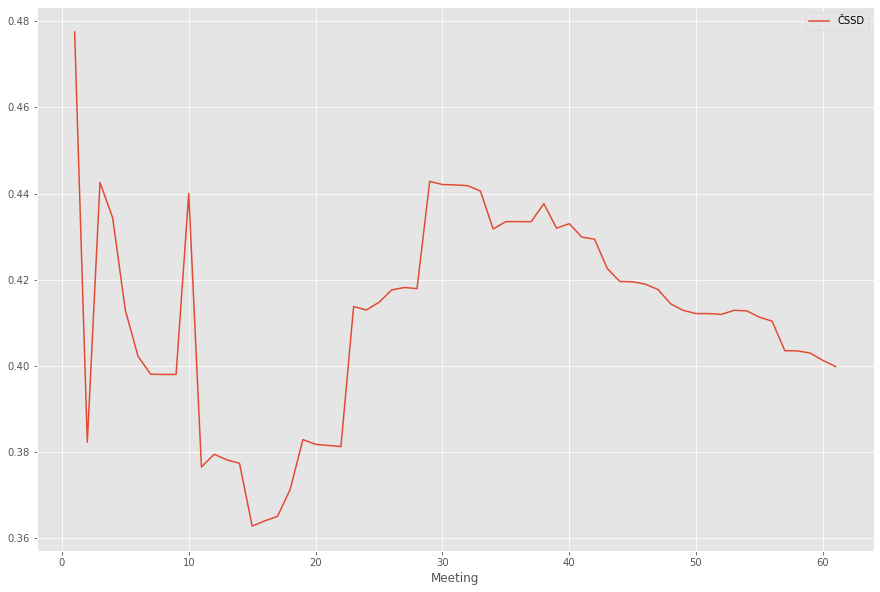

In [115]:
fig, ax = plt.subplots(figsize=(15,10))    
party_data[party_data['Party'] == 'ČSSD'].plot(x='Meeting', y='Ratio', ax=ax, label=party)